# Flow Around An Airfoil

TODO: General Intro

First, we specify the input parameters that can be changed; We can play around with these later.

In [547]:
airfoil_angle = 10. # degrees 
airspeed = 450. # m/s

Nex, we import some external libraries: No need to write the code ourselves if others have already done it. No need to look at this in detail!

In [548]:
import numpy as np  # general math library
import pygmsh  # divides air flow region into triangular cells
from matplotlib import pyplot as plt  # plots graphics
from matplotlib import colormaps, colors, colorbar, path  # some more libraries to help with plotting
from scipy.interpolate import griddata  # this helps with plotting streamlines of air

We divide the air flow region around the arifoil into triangular cells. This is called a "mesh" or a "grid".

We use an external library for this.

In [549]:
# Load airfoil geometry from file
naca = np.loadtxt('naca0012.csv', skiprows=9, delimiter=',')[::3,:]/100.

# divide air flow region into triangular cells. 
with pygmsh.occ.Geometry() as geom:
    # domain border: circle with radius 5
    outer = geom.add_disk([0.0, 0.0], 5.0, mesh_size=1.0)
    inner = geom.add_polygon(naca, mesh_size=0.1,
    )
    geom.boolean_difference(outer, inner)
    mesh = geom.generate_mesh()
nodes = mesh.points[:,:2]
alpha = airfoil_angle*np.pi/180.
nodes[:,0], nodes[:,1] = nodes[:,0]*np.cos(alpha) + nodes[:,1]*np.sin(alpha), nodes[:,1]*np.cos(alpha) - nodes[:,0]*np.sin(alpha)
cells = mesh.cells_dict['triangle']

/home/jakob/.local/lib/python3.8/site-packages/pygmsh/occ/geometry.py:221: UserWarning: Specified mesh size for <pygmsh Disk object, ID 1> discarded in Boolean difference operation.
  warnings.warn(


This code gives us two arrays:
- The `nodes` array contains coordinates of all the corners of the triangles. For example, node number 354 has `x=0.26` and `y=0.51`. 
- The `cells` array contains the nodes that make up each cell. For example, cell number 17 has the corner nodes number 254, 341 and 12. 

Let's have a look at the grid we have generated!

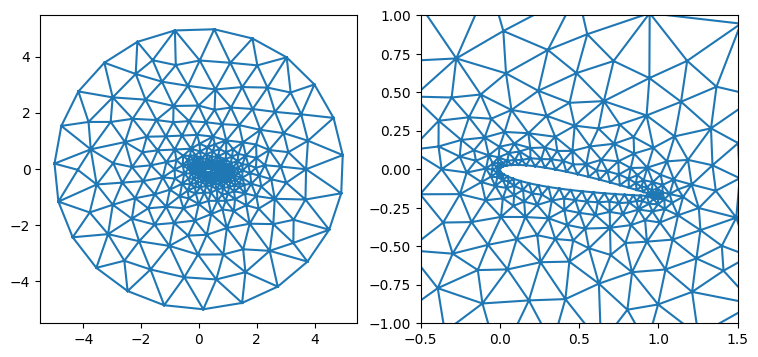

<Figure size 640x480 with 0 Axes>

In [550]:
# plot cells in graph 
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(9, 4)
plt.figure() 
ax[0].triplot(nodes[:,0], nodes[:,1], cells)
ax[1].triplot(nodes[:,0], nodes[:,1], cells)
dummy = ax[1].axis([-0.5, 1.5, -1., 1.])

We want to calculate how much air flows from one cell into another. For this, some information on how the cells are connected, In particular, we need: 
- An array of `sides`, each of which connects to adjacent cells. Later, we will calculate how much air flows over which side.
- An array `cell2side` that maps each cell to its three sides. For example, the sides 35, 85 and 293 make up cell number 105. 
- An array that maps each side to its two neighbouring cells. For example, side number 35 connects elements number 105 and 212.  

We also need information on where the air flow region we want to investigate ends. We call these sides *boundary* sides. We sepcify two kinds of boundaries: the one around the airfoil is a wall, i.e. no air can flow through these sides. For the outer boundary, we define that the air condition outside of it is always at a constant state that we prescribe. 

In [551]:
# CONNECTIVITY
n_cells = cells.shape[0]
sides = np.concatenate((cells[:,:2], cells[:,1:], cells[:,::-2]))

sides, uniquesideids, cell2side_flat = np.unique(np.sort(sides), axis=0, return_index=True, return_inverse=True)
n_sides = sides.shape[0]
cell2side = np.transpose(np.reshape(cell2side_flat, (3, n_cells)))

# build side2cell
cell_ind = np.mod(np.arange(3*n_cells), n_cells)
sideid_2_cellid = np.transpose(np.stack((cell2side_flat, cell_ind)))
side2cell = np.zeros((n_sides, 2)).astype(int)-1
side2cell[sideid_2_cellid[uniquesideids,0],0] = sideid_2_cellid[uniquesideids,1]
sideid_2_cellid = np.delete(sideid_2_cellid, uniquesideids, axis=0)
side2cell[sideid_2_cellid[:,0],1] = sideid_2_cellid[:,1]

# boundaries
bcsides = np.argwhere(side2cell[:,1]<0)[:,0]
bc_wall = bcsides[np.linalg.norm(nodes[sides[bcsides,0],:], axis=1)<2.]
bc_outr = bcsides[np.linalg.norm(nodes[sides[bcsides,0],:], axis=1)>2.] 

We need some further geometric information on our mesh of cells: 
- The `volume` (i.e. area, since we are two-dimensional) of each cell
- The `length` of each side between two cells
- The direction/angle of each side. We express this as the `normal` vector, i.e. the direction orthogonal to the side. 
- The location of the center of each side `x_side` and of each cell `x_cell`

If air flows from one cell into another, the flowing mass is subtracted from one cell and added to another. We need to define a direction for each side, i.e. which cell a positive flow gets subtracted from and which it gets added to. In other words, we have to define whether a positive velocity means from cell 1 to cell 2 or the other way round. We do this with an array we call `outward_factor`. For each side, we set it to -1 for one nighbouring cell and to +1 for the other. 

In [552]:
# metrics 
volume = np.abs(np.cross(nodes[cells[:,1],:]-nodes[cells[:,0],:], nodes[cells[:,2],:]-nodes[cells[:,0],:], axis=1))/2.
diff = nodes[sides[:,1],:] - nodes[sides[:,0],:]
length = np.linalg.norm(diff, axis=1)
normal = np.stack((diff[:,1]/length , -diff[:,0]/length), axis = 1) 
x_cell = (nodes[cells[:,0],:] + nodes[cells[:,1],:] + nodes[cells[:,2],:])/3.
x_side = (nodes[sides[:,0],:] + nodes[sides[:,1],:]) / 2.

# normal vector needs to always point from 'first' neighbouring cell into 'second': Flip those that are wrong
leftbary2side_vec = x_side - x_cell[side2cell[:,0],:]
is_wrong_direction = np.sum(leftbary2side_vec*normal, axis=1)  < 0.
normal[is_wrong_direction,:] *= -1.

# Define for each side if a 'positive' flow means that air flows out of the cell or into it.
# set all to outward (-1) at first
outward_factor=np.zeros_like(cell2side) - 1
for iside in range(3):
    # inward are those where the cellID is second entry of side2cell
    outward_factor[side2cell[cell2side[:,iside],1] == np.arange(n_cells),iside] = 1. 

In [553]:
# solution arrays
u = np.zeros((n_cells, 4))
up = np.zeros((n_cells, 4))

# define indices

# conservative variables
DENS = 0
MOMX = 1
MOMY = 2 
ENER = 3

# primitive variables
# DENS = 0 (already defined)
VELX = 1
VELY = 2
PRES = 3

In [ ]:

def constoprim(u):
    up = u.copy()
    up[:,VELX] = u[:,MOMX] / u[:,DENS]
    up[:,VELY] = u[:,MOMY] / u[:,DENS]
    up[:,PRES] = 0.4*(u[:,ENER] - 0.5* u[:,DENS] * (up[:,VELX]**2 + up[:,VELY]**2) )
    return up


def primtocons(up):
    u = up.copy()
    u[:,MOMX] = up[:,VELX] * up[:,DENS]
    u[:,MOMY] = up[:,VELY] * up[:,DENS]
    u[:,ENER] = up[:,PRES]*2.5 + 0.5* up[:,DENS] * (up[:,VELX]**2 + up[:,VELY]**2)
    return up

freeflow_prim = np.zeros((1,4))
freeflow_prim[:,DENS] = 1.225  # kg/m^3
freeflow_prim[:,VELX] = airspeed   # m/s
freeflow_prim[:,VELY] = 0.     # m/s
freeflow_prim[:,PRES] = 101300 # Pascal (100000 Pa = 1bar)

freeflow = primtocons(freeflow_prim)

u[:,:] = freeflow

u_left = np.zeros((n_sides, 4))
u_right = np.zeros((n_sides, 4))

u_right[bc_outr,:] = freeflow

# calculate flux 


In [554]:


# rotation directions: 
FWD = 1
BWD = -1
def rotate(a, dir=FWD): 
    a[:,MOMX], a[:,MOMY] = a[:,MOMX]*normal[:,0] + dir*a[:,MOMY]*normal[:,1], a[:,MOMY]*normal[:,0] - dir*a[:,MOMX]*normal[:,1]


def fill_sides():
    # fill sides
    u_left[:,:] = u[side2cell[:,0],:]
    u_right[:,:] = u[side2cell[:,1],:]

    # fill BC sides 
    u_right[bc_outr,:] = freeflow

    rotate(u_left, dir=FWD)
    rotate(u_right, dir=FWD)

    u_right[bc_wall,:] = u_left[bc_wall,:] 
    u_right[bc_wall,MOMX] *= -1

    return u_left, u_right

def flux(u, up):
    f = np.zeros_like(u)
    
    f[:,DENS] = up[:,VELX] * up[:,DENS]
    f[:,MOMX] = up[:,VELX]**2 * up[:,DENS] + up[:,PRES]
    f[:,MOMY] = up[:,VELX]*up[:,VELY]*up[:,DENS]
    f[:,ENER] = up[:,VELX]*( u[:,ENER] + up[:,PRES] )
    return f

def calc_flux(): 
    up_left = constoprim(u_left)
    up_right = constoprim(u_right)

    f_left = flux(u_left, up_left) 
    f_right = flux(u_right, up_right) 

    a = np.maximum(lmbda(up_left), lmbda(up_right))
    f = 0.5 * (f_left + f_right) - 0.5 * a[...,np.newaxis] * (u_right-u_left)
    return f


def sos(up): 
    return np.sqrt(1.4*up[:,PRES]/up[:,DENS])


def lmbda(up): 
    return sos(up)+np.sqrt(up[:,VELX]**2+up[:,VELY]**2)

def timestep(up, dx): 
    return 0.99*dx/np.max(lmbda(up))

def change_of_state(f): 

    # rotate back
    rotate(f, dir=BWD)

    up = constoprim(u)
    if np.min(up[:,DENS]) < 0. or np.min(up[:,PRES]) < 0.:   
        raise Exception(f"Negative pressure or density encountered!")
    time_step = timestep(up, 0.001)

    # add flux to cells 
    f = f * np.reshape(length,(n_sides,1))
    f_cell = np.zeros_like(u)
    for iside in range(3): 
        f_cell = f_cell + f[cell2side[:,iside],:] / np.reshape( volume * outward_factor[:,iside], (n_cells,1))
    return time_step * f_cell

In [555]:

for i_timestep in range(3000): 
    u_left, u_right = fill_sides() 
    f = calc_flux()
    u = u + change_of_state(f)

After the simulation is finished, we calculate the forces (i.e. the lift and drag) that the air exerts on the airfoil.
For this, we need the pressure on each wall boundary side, which e multiply by each side length. The direction of the pressure is given by the normal vector of the side. 

We add all these forces to get the resulting force `fsum` (which is a 2D-vector) and its total strength `fsum_abs`. 
We can also calculate the point `x_force` where this force is applied 'on average'
We use these values to plot a force arrow into the figure below. Its width is proportional to the strength of the force.

In [556]:
forces = (primtocons(u[side2cell[bc_wall,0],:])[:,PRES] - freeflow_prim[:,PRES]) * length[bc_wall]
forces = forces[...,np.newaxis] * normal[bc_wall,:]
fsum = np.sum(forces, axis=0)
fsum_abs = np.linalg.norm(fsum)
x_force = np.sum(x_side[bc_wall,:]*forces[:,::-1], axis=0)/fsum[::-1]

The rest is just plotting... 

/home/jakob/.local/lib/python3.8/site-packages/matplotlib/collections.py:576: UserWarning: Warning: converting a masked element to nan.
  self._us_lw = np.atleast_1d(np.asarray(lw))


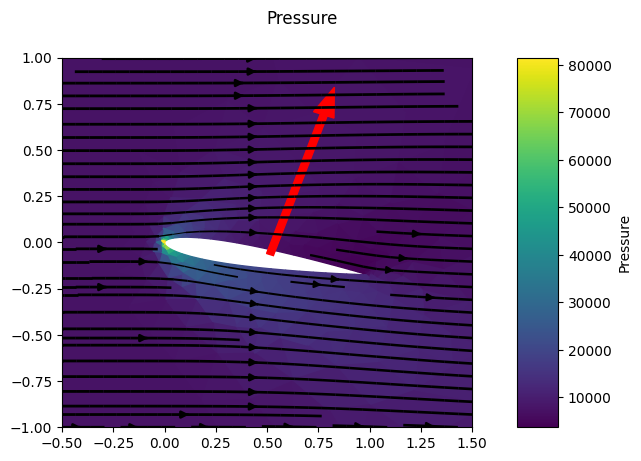

In [557]:
def plot(u_all, index, title):

    up = constoprim(u_all)
    u = up[:,index]

    xmin, xmax, ymin, ymax = -0.5, 1.5, -1., 1.
    fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios': [10, 1]}) 

    # PRESSURE FIELD
    # colors 
    umin, umax = np.min(u), np.max(u)
    umid = (umin+umax)/2.
    umin = np.minimum(umin, umid-0.01)
    umax = np.maximum(umax, umid+0.01)
    cnorm = colors.Normalize(umin, umax)
    cmap = colormaps.get_cmap('viridis')
    # actual plot
    for icell in range(n_cells): 
        ax[0].fill(nodes[cells[icell,:],0], nodes[cells[icell,:],1], color = cmap(cnorm(u[icell])))

    # STREAMLINE PLOT 
    # interpolate to Cartesian grid
    ncart = 100
    xcart, ycart = np.meshgrid(np.linspace(xmin,xmax,ncart), np.linspace(ymin,ymax,ncart))
    index_use = np.maximum(np.abs(x_cell[:,0] - (xmax+xmin)/2.)/(xmax-xmin), np.abs(x_cell[:,1] - (ymax+ymin)/2.)/(ymax-ymin)) < 0.6
    vx_cart = griddata(x_cell[index_use,:], up[index_use,VELX], (xcart, ycart))
    vy_cart = griddata(x_cell[index_use,:], up[index_use,VELY], (xcart, ycart))
    # create airfoil masking
    rnaca = naca.copy()
    rnaca[:,0], rnaca[:,1] = rnaca[:,0]*np.cos(alpha) + rnaca[:,1]*np.sin(alpha), rnaca[:,1]*np.cos(alpha) - rnaca[:,0]*np.sin(alpha)
    npath = path.Path(rnaca)
    mask = npath.contains_points(np.transpose(np.vstack([xcart.ravel(), ycart.ravel()]))).reshape((ncart,ncart))
    vx_masked = np.ma.array(vx_cart, mask=mask)
    vy_masked = np.ma.array(vy_cart, mask=mask)
    # calculate linewidth from velocity
    v_masked = np.ma.sqrt(vx_masked**2+vy_masked**2)
    v_ff = np.linalg.norm(freeflow[0,MOMX:MOMY+1])/freeflow[0,DENS]
    lw = 2. + 5.*(v_masked-v_ff)/v_ff 
    # show streamplot
    ax[0].streamplot(xcart, ycart, vx_masked, vy_masked, color='black', linewidth = lw)

    # FORCE ARROW
    ax[0].arrow(x_force[0], x_force[1], 0.8*fsum[0]/fsum_abs, 0.8*fsum[1]/fsum_abs, color='r', width = 5.e-7*fsum_abs)
    # set region to show
    _ = ax[0].axis([xmin, xmax, ymin, ymax])

    # add color legend on the right 
    cb1 = colorbar.ColorbarBase(ax[1], 
                                cmap=cmap,
                                norm=cnorm,
                                orientation='vertical')
    cb1.set_label(title)

    fig.suptitle(title)
    fig.show()


And taddaaa...

In [ ]:

plot(u, PRES, 'Pressure')